In [15]:
### 03. 데이터 준비하기.ipynb의 내용 (scaled_data 사용하기 위한 코드)
import pandas as pd
import seaborn as sns

# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format

sales_df = pd.read_csv('data/sales_data.csv', index_col=['customer_id'])
sales_df
# =====
# 이상치 제거 함수
def get_outlier_mask(df, weight=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 = Q1
    IQR_weight = IQR * weight

    range_min = Q1 - IQR_weight  # 정상범위의 최소값
    range_max = Q3 + IQR_weight  # 정상범위의 최대값

    outlier_per_column = (df < range_min) | (df > range_max)  # 최소값보다 작거나, 최대값보다 크면 이상치로 간주. 
                                                              # -> 불린값을 Pandas Series로 반환..할 듯
    
    is_outlier = outlier_per_column.any(axis=1)  # 각 행에 대하여 True 혹은 False 값을 가진 Pandas Series가 반환됨. (True이면 이상치.)

    return is_outlier
# =====
outlier_idx_cust_df = get_outlier_mask(sales_df, weight=1.5)  # True/False 값을 가진 Pandas Series가 반환됨.

# 아웃라이어 제거한 데이터 프레임만 추가
sales_df = sales_df[~outlier_idx_cust_df]
# =====
df_mean = sales_df.mean()  # 각 컬럼의 평균값
df_std = sales_df.std()  # 각 컬럼의 표준편차

scaled_df = (sales_df - df_mean) / df_std  # 컬럼별 표준화 진행 ~> 이게 왜 표준화가 되지?

# 컬럼명 설정.
scaled_df.columns = ['total_buy_cnt', 'total_price']

# 인덱스 설정
scaled_df.index = sales_df.index

scaled_df

,total_buy_cnt,total_price
customer_id,,
12471,-0.99,-0.66
12557,-0.40,-0.71
12600,-0.88,0.33
12686,1.74,0.57
12748,-0.74,-0.60
...,...,...
17949,-1.33,-0.45
17951,-0.03,0.50
18085,0.93,1.59


## 모델과 학습
모델은 넓게 두 가지 의미가 있는데요, 지금까지 사용해왔던 것 처럼 그냥 구체적인 분석 방법론을 의미하기도 하고,  
이 분석법을 적용하고 그 결과물을 저장할 수 있는 프로그램을 의미하기도 합니다.

학습은 넓은 의미에서는 그냥 모델에게 데이터를 전달해서 분석을 시키는 과정입니다.

우리가 이번 레슨에서 하려는 것처럼 k-means 모델을 학습시킨다는 건,  
k-means 분석법이 저장된 프로그램에게 분석하길 원하는 데이터를 전달해서 결과물을 저장하겠다는 거죠.

## k-means 모델 학습

k-means를 할 때에는 scikit-learn이라는 라이브러리가 사용됩니다.

In [17]:
from sklearn.cluster import KMeans

scikit-learn: 데이터 분석을 위한 여러 작업을 간단하게 처리해주는 라이브러리.  
[>> scikit-learn 라이브러리 사용법](https://www.codeit.kr/tutorials/39/scikit-learn-%EC%82%AC%EC%9A%A9%ED%95%B4-%EB%B3%B4%EA%B8%B0)

In [18]:
# k-means (k=2)
model = KMeans(n_clusters=2, random_state=123)

>[ 코드 코멘트 ]
>KMeans의 파라미터
>- n_clusters: 클러스터를 몇 개로 나눌지 결정, 즉 k 값 결정.  
>    참고) k의 값에 따라 모델의 성능이 크게 달라진다.
>
>- random_state: 여러 번 반복해서 모델을 학습시킬 때 동일한 결과가 나올 수 있도록 해 주는 난수.

In [19]:
# 모델 학습
model.fit(scaled_df)

c:\Users\emma1\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2, random_state=123)

## 클러스터 시각화

이제 구분된 클러스터를 직접 확인해 볼게요.  
먼저, `predict()`를 활용해 각 데이터가 어떤 클러스터로 구분됐는지 표시합니다. 해당 값을 `scaled_df`에 새로운 열 (`lable`)로 추가할게요.

In [ ]:
# label 컬럼 생성
scaled_df['label'] = model.predict(scaled_df)  # 이 label에는 각 행이 어느 클러스터로 군집화 되었는지가 들어있음.

scaled_df

,total_buy_cnt,total_price,label
customer_id,,,
12471,-0.99,-0.66,0
12557,-0.40,-0.71,0
12600,-0.88,0.33,0
12686,1.74,0.57,1
12748,-0.74,-0.60,0
...,...,...,...
17949,-1.33,-0.45,0
17951,-0.03,0.50,0
18085,0.93,1.59,1


라벨링 된 데이터를 기준으로 클러스터를 구분해 시각화 해보고, 거기에 Centroid도 함께 표시해 보겠습니다.  
(Centroid는 `moel.cluster_centers_`로 값을 받아옵니다.)

<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

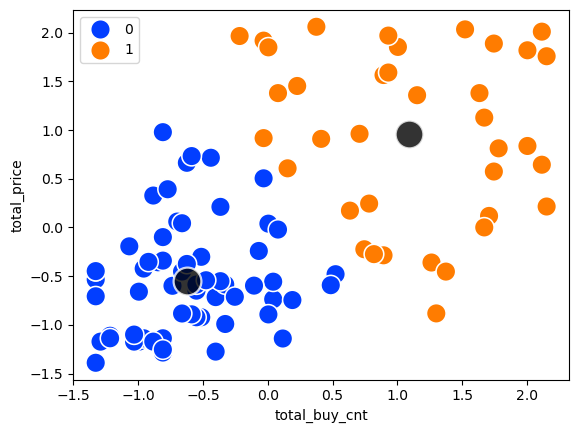

In [21]:
# 각 군집의 중심점
centers = model.cluster_centers_

# 클러스터 시각화
sns.scatterplot(x=scaled_df['total_buy_cnt'], y=scaled_df['total_price'], hue=scaled_df['label'], s=200, palette='bright')
# Centroid 시각화
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='black', alpha=0.8, s=400)  # Centroid는 큰 검정색 원으로 표시